사용 모듈

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
image_width = 224
image_height = 224

데이터 불러오기

In [3]:
Path="C:\\Project1\\"
train_files = []
mask_files = glob(Path+'lgg-mri-segmentation\\kaggle_3m\\*\\*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_49

데이터 확인

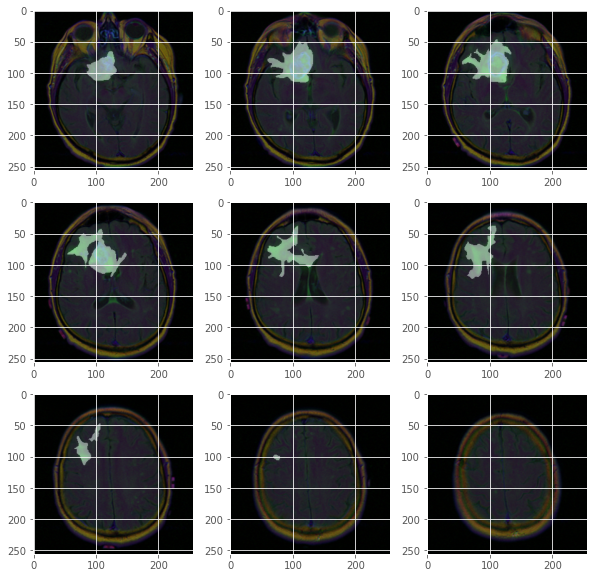

In [4]:
rows, cols = 3,3
fig = plt.figure(figsize=(10,10))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    msk_path = mask_files[i]
    img = cv2.imread(img_path)
    if img is None:
        print('Wrong path:', img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
plt.show()


In [5]:
df = pd.DataFrame(data={'filename': train_files, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.1)
df_train, df_val = train_test_split(df_train, test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


Train Image 변형

In [6]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(image_height,image_width),
        seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)
        
def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [7]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

Unet model

In [8]:
def vgg16_Unet(input_size=(224,224,3)):
    inputs = Input(input_size)
    # inputs = Input(shape=input_size, dtype='float32', name='input')

    """Encoder"""
    c1 = tf.keras.layers.Conv2DTranspose(64,(3,3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2DTranspose(64,(3,3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2), name='pool1')(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',  padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',  padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2), name='pool2')(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',  padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',  padding='same')(c3)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',  padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2), name='pool3')(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2), name='pool4')(c4)

    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    p5 = tf.keras.layers.MaxPooling2D((2, 2), name='pool5')(c5)
    
    """Decoder"""
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization(axis=3)(c6)
    c6 = Activation('relu')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization(axis=3)(c7)
    c7 = Activation('relu')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization(axis=3)(c8)
    c8 = Activation('relu')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization(axis=3)(c9)
    c9 = Activation('relu')(c9)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [9]:
model = vgg16_Unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

하이퍼 파라미터

In [10]:
EPOCHS = 10
BATCH_SIZE = 32
learning_rate = 1e-4

#learning_rate_schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# learning_rate_cosine_schedule
lr_cosine_schedule = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate= 1e-2, 
    first_decay_steps= 100 , 
    t_mul=2.0, 
    m_mul=1.0, 
    alpha=0.0,
    name=None
)


학습 시작

In [11]:
# # learning_rate_scheldule
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# # learning_rate_cosine
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_cosine_schedule), loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(image_height, image_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(image_height, image_width))

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_vgg16_Unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

C:\Users\82105\anaconda3\envs\ai_02\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
89/88 [==============================] - ETA: -26s - loss: 9.8504 - binary_accuracy: 0.8977 - iou: 0.0771 - dice_coef: 0.1374Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 4027s 45s/step - loss: 9.8504 - binary_accuracy: 0.8977 - iou: 0.0771 - dice_coef: 0.1374 - val_loss: 0.8651 - val_binary_accuracy: 0.9168 - val_iou: 0.0907 - val_dice_coef: 0.1626

Epoch 00001: val_loss improved from inf to 0.86509, saving model to unet_brain_mri_vgg16_Unet.hdf5
Epoch 2/10
88/88 [==============================] - 3936s 45s/step - loss: 0.2660 - binary_accuracy: 0.9896 - iou: 0.2951 - dice_coef: 0.4441 - val_loss: 0.1220 - val_binary_accuracy: 0.9837 - val_iou: 0.2711 - val_dice_coef: 0.4124

Epoch 00002: val_loss improved from 0.86509 to 0.12197, saving model to unet_brain_mri_vgg16_Unet.hdf5
Epoch 3/10
88/88 [==============================] - 393

Loss 및 Accuraacy 그래프

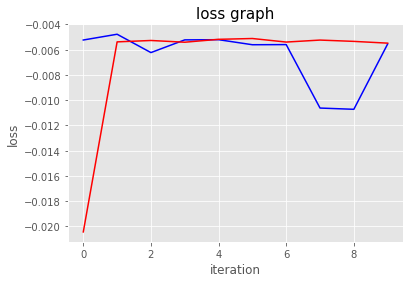

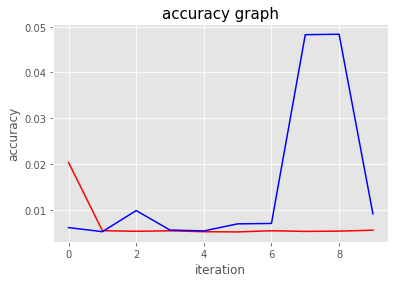

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

결과 도출

In [ ]:
model = load_model('unet_brain_mri_vgg16_Unet.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

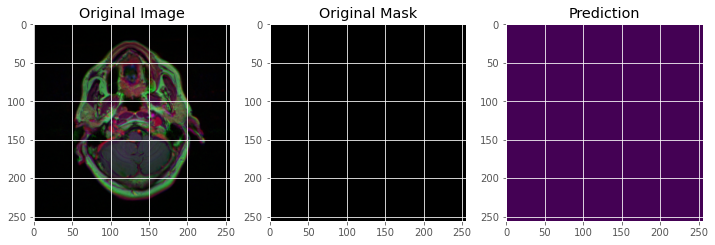

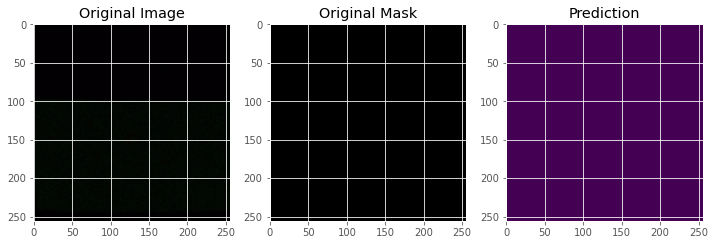

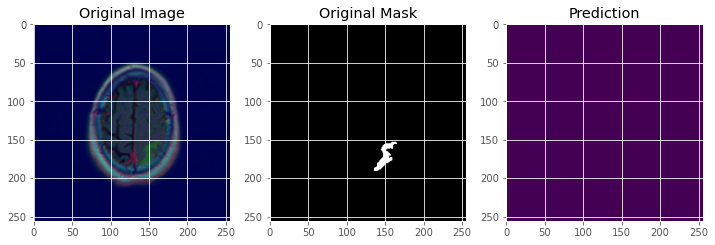

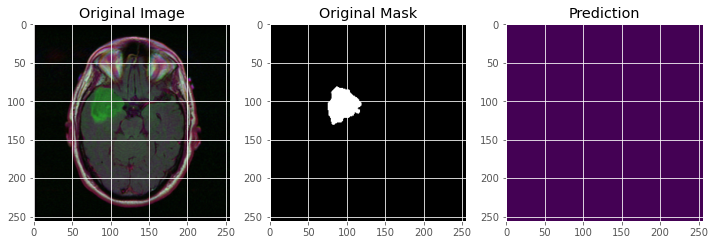

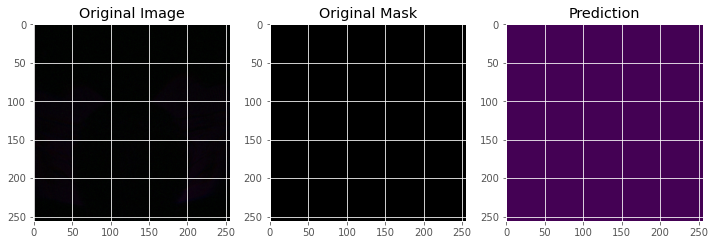

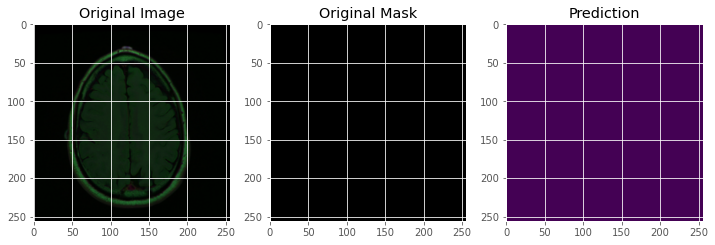

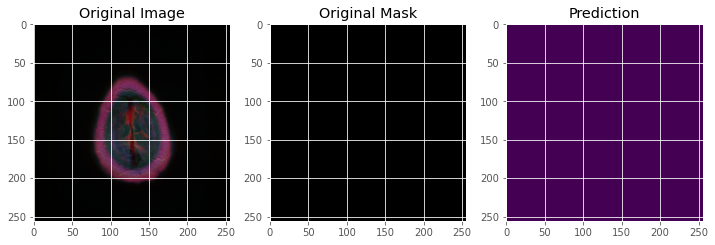

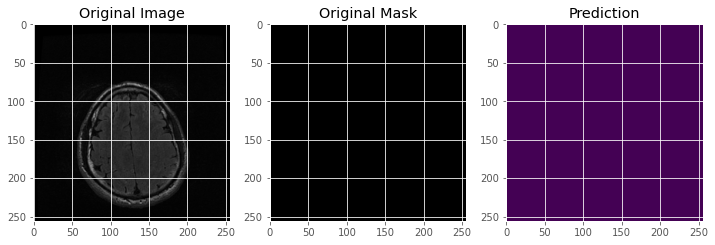

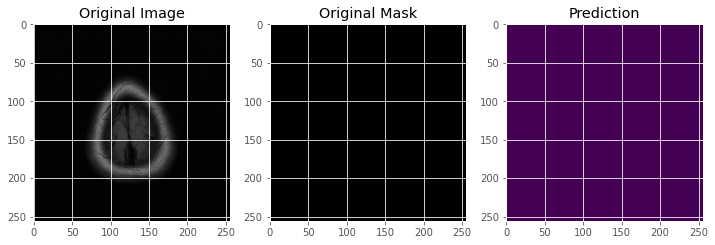

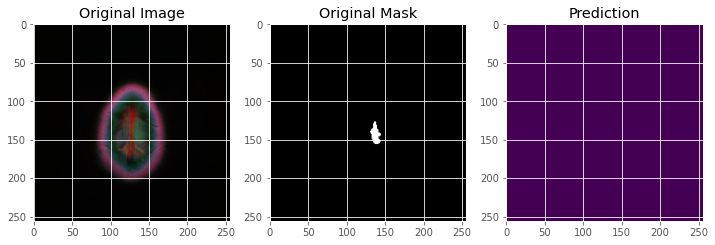

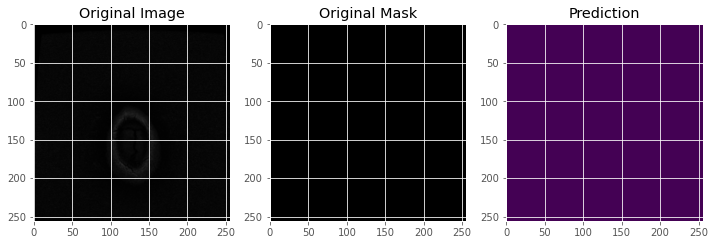

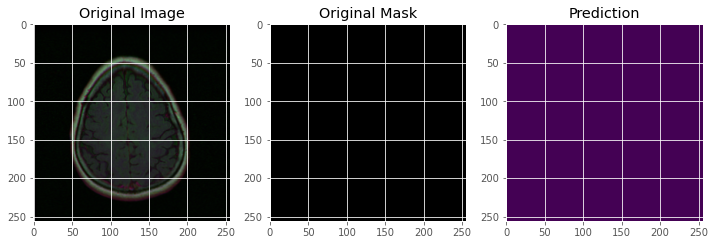

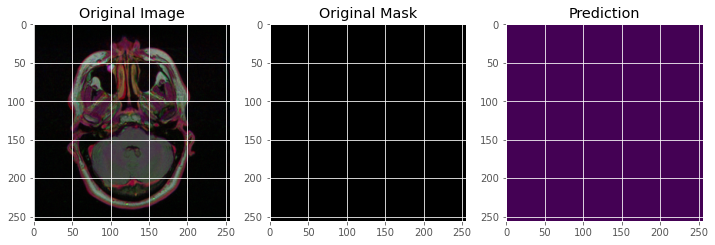

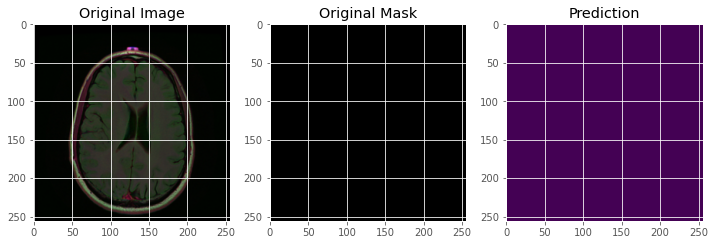

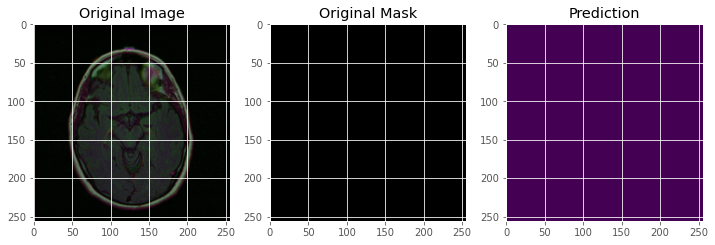

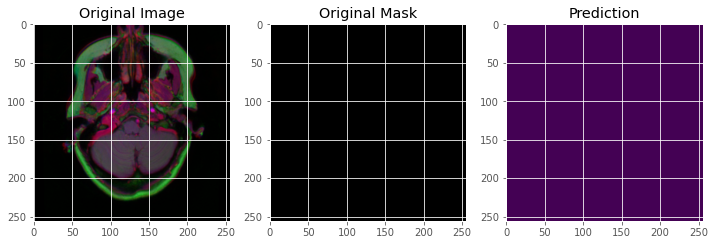

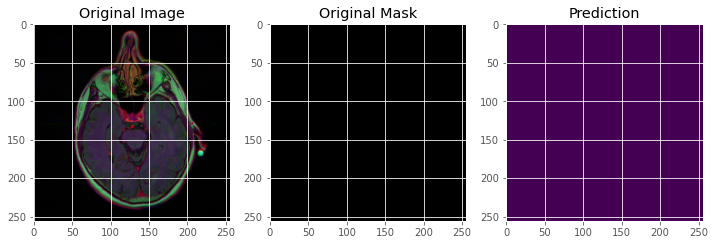

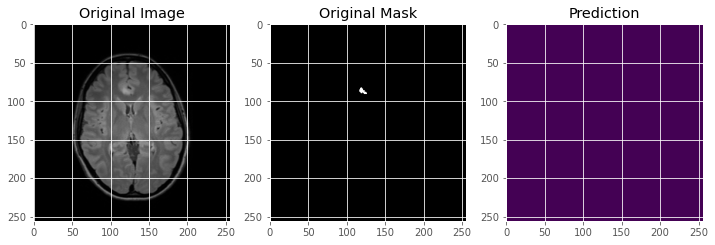

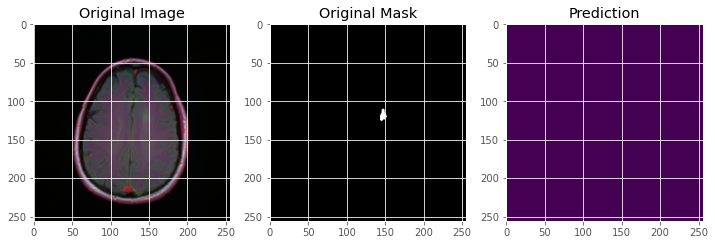

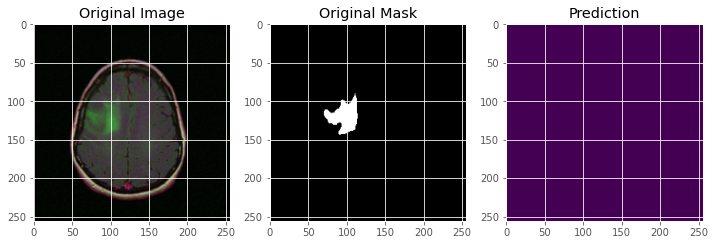

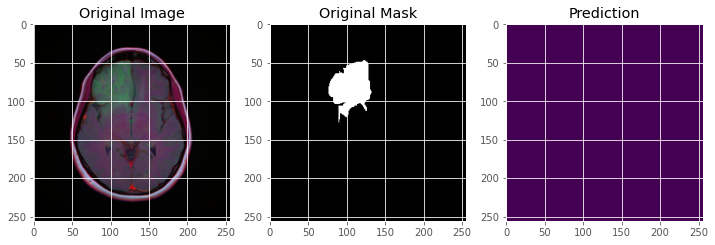

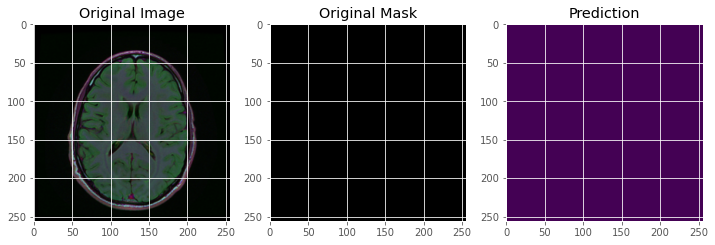

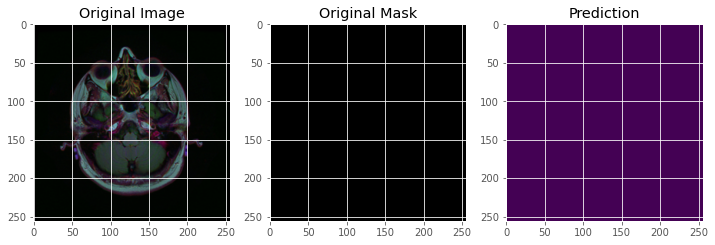

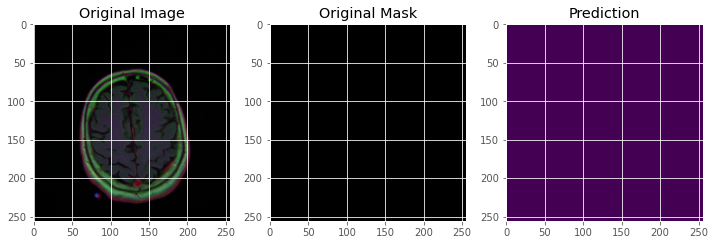

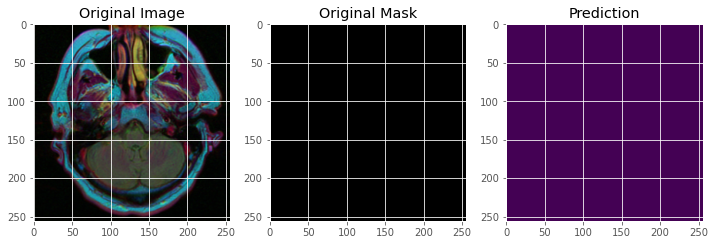

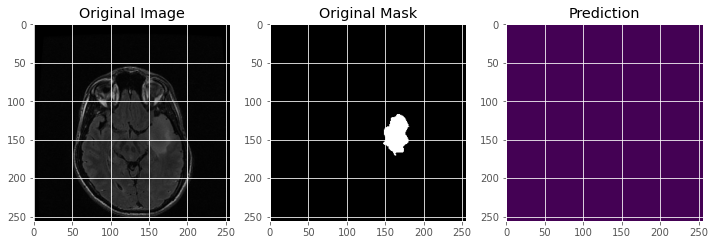

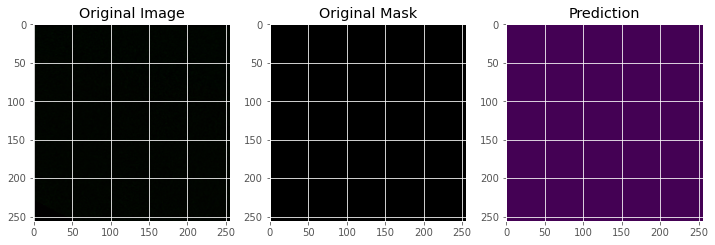

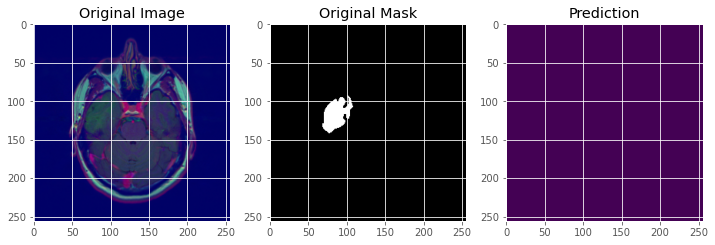

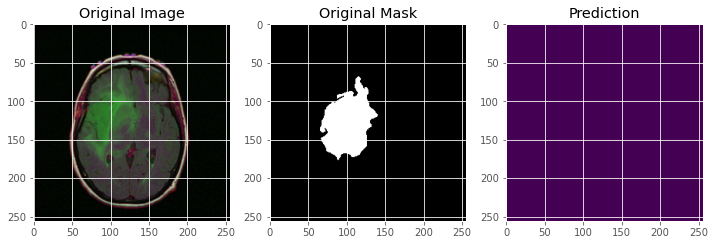

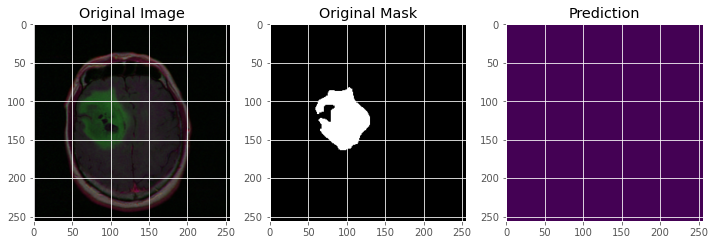

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(image_height, image_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()